# Case Study - Machine Learning
### Mähdrescher oder Traktor?

Dieses Case Study zeigt, wie durch Machine Learning ein Neuronales Netzwerks trainiert werden kann, um einen Bild-Klassifizierer zu erstellen, der beispielsweise Mähdrescherbilder von Traktorbildern unterscheidet.

Die Grundlagen zu diesem Workshop kommen aus dem Deep Learning MOOC [fast.ai](http://fast.ai) (Version 1) von Jeremy Howard.


### Einstieg

Zunächst mal: Wie ist der Begriff einzuordnen?

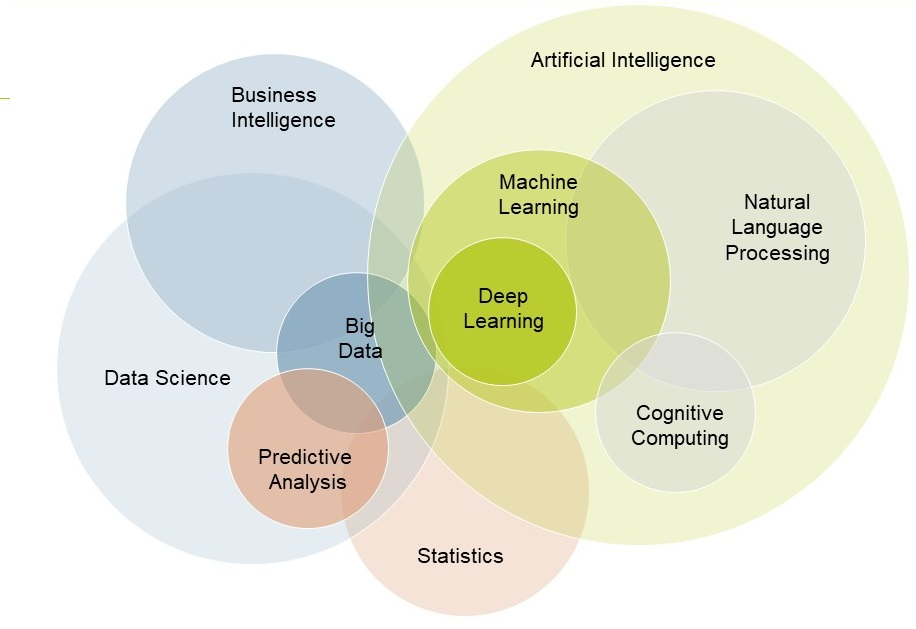

Unter Machine Learning können allgemein Methoden verstanden werden, um mithilfe von Lernprozessen Muster und Zusammenhänge in bestehenden Datensätzen zu erkennen und zur Vorhersage neuer Daten anzuwenden.

Maschinelle Lernverfahren können in die drei Kategorien überwachtes Lernen (engl. supervised learning), unbewachtes Lernen (engl. unsupervised learning) und bestärkendes Lernen (engl. reinforcement learning) unterteilt werden. 

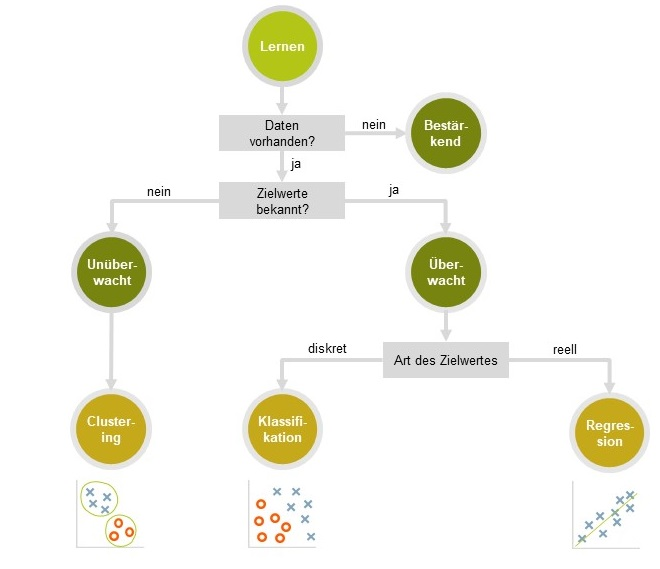

Beim überwachten Lernen wird anhand von Trainingsdaten eine Funktion bestimmt, die gegebene Eingabewerte auf bekannte Zielwerte abbildet. Unüberwachte  Lernverfahren werden indes eingesetzt, wenn keine Zielwerte bekannt sind, um anhand der Eingabedaten bislang unbekannte Muster und Strukturen aus einer Datenmenge abzuleiten und ähnliche Objekte zu gruppieren. Beim bestärkenden Lernen basieren die Lernalgorithmen auf Belohnungen und Bestrafungen, mit dem Ziel, den Nutzen zu maximieren.

> 🚩 **Frage: Um welche Art des Machine Learning handelt es sich bei dieser Case Study?**


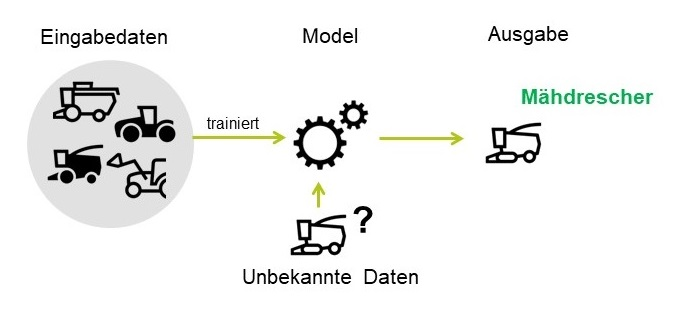

### Setup

Zu Beginn müssen alle notwendigen Bibliotheken importiert werden.


In [1]:
# Importiere Bibliotheken
import numpy as np
import pandas as pd
import os 
import random

# # Importiere Bibliotheken zur Datenvisualisierung
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2

# Importiere Bibliothek für Tensorflow
import tensorflow
from keras.preprocessing.image import ImageDataGenerator

# Aktiviere inline-Plotting
%matplotlib inline

### Vorbereitung der Daten

Überwachte Lernverfahren setzen gelabelte Datensätze mit Ein- und 
Ausgabewerten voraus, um ein Vorhersagemodell zu erlernen. Ziel ist es, nach dem Trainingsprozess anhand von Eingaben (Bilder) die Ausgabe (Klasse) mit einer möglichst hohen Genauigkeit vorherzusagen. Für den Traininsprozess werden die Daten in einen Trainings- und Validierungsdatensatz aufgeteilt. Während des 
eigentlichen Lernprozesses wird anhand der beiden Datensätzen eine Funktion unter Minimierung einer Verlustfunktion approximiert.

Zusätzlich sollten auch Bilder für einen Testdatensatz gesammelt werden, die während des Trainings nicht verwendet werden. Damit kann später das fertig trainierte Modell anhand unbekannter Bilder getestet werden.

BILD

Folgende Struktur ist vorgesehen:
* Im Verzeichnis `train` werden die Trainingsdaten abgelegt, unterteilt in `tractors` und `combines`.
* Im Verzeichnis `valid` sind die Validerungsdaten für das Training (ebenfalls in `tractors` und `combines` unterteilt).
* Im Verzeichnis `test` werden die Bilder zur späteren Klassifizierung abgelegt. 


> 🚩 **Sammel im Internet Bilder zu Mähdreschern und Traktoren, lade diese herunter und lege sie in den bereits vorbereiteten Verzeichnissen ab. Grundsätzlich gilt, je mehr Bilder zum Training vorhanden sind, desto höher ist später die Genauigkeit des trainierten Modells. Bedenke eine sinnvolle Verteilung zwischen Trainings- und Validierungsdatensatz.**

> Fotos aus der CLAAS-Welt können z.B. hier gefunden werden:
- https://www.claas.de/apps-medien/medien/downloadcenter
- https://www.claas-gruppe.com/presse/medien/pressebilder

In [2]:
# Googel Drive einbinden
from google.colab import drive
drive.mount('/content/drive')

# Pfad definieren
import pandas as pd
path = "/content/drive/MyDrive/ml" # Verzeichnis in Google Drive, ggf. anpassen

# Definition der Pfade 
TrainingImagePath= f"{path}/train"
TestingImagePath= f"{path}/test"
ValidationImagePath= f"{path}/valid"

# Anzahl der Bilder in jedem Unterordner ausgeben
for subdir, dirs, files in os.walk(TrainingImagePath):
    print(f"Anzahl der Bilder in Unterordner {subdir}: {len(files)}")
for subdir, dirs, files in os.walk(TestingImagePath):
    print(f"Anzahl der Bilder in Unterordner {subdir}: {len(files)}")
for subdir, dirs, files in os.walk(ValidationImagePath):
    print(f"Anzahl der Bilder in Unterordner {subdir}: {len(files)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/train: 0
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/train/tractors: 10
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/train/combines: 10
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/test: 0
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/test/tractors: 1
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/test/combines: 1
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/valid: 0
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/valid/combines: 4
Anzahl der Bilder in Unterordner /content/drive/MyDrive/ml/valid/tractors: 4


Zur Kontrolle werden fünf zufällige Bilder des Trainingsdatensatz angezeigt:

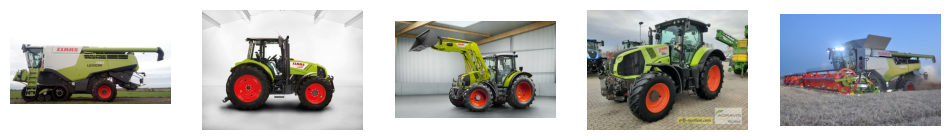

In [3]:
# Eine leere Liste für die Bilddateipfade erstellen
image_paths = []

# Durch alle Unterordner in dem Verzeichnis iterieren
for root, dirs, files in os.walk(TrainingImagePath):
  for file in files:
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
      image_paths.append(os.path.join(root, file))

# Fünf zufällige Bilder auswählen
random_files = random.sample(image_paths, 5)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

# Für jedes der zufällig ausgewählten Bilder ein subplot in der Figure erstellen
for i, image_path in enumerate(random_files):
  image = plt.imread(image_path)
  ax[i].imshow(image)
  ax[i].axis('off')

# Die Matplotlib-Figur anzeigen
plt.show()

Im nächsten Schritt werden die Bilder durch verschiedenen Vorverarbeitungsschritte transformiert und für die Verwendung in einem neuronalen Netzwerk vorbereitet. Durch Kippen, Zoomen und Spiegeln werden verschiedene Varianten des gleichen Bildes erstellt, die dann als separate Trainingsbeispiele behandelt werden können.

In [4]:
# Definition der Vorverarbeitung für Trainingsdatensatz
train_datagen = ImageDataGenerator(
        rescale=1./255,  # Skalierung der Pixelwerte auf den Bereich von 0 bis 1
        shear_range=0.1,  # zufällige Verzerrung der Bilder durch Kippen
        zoom_range=0.1,  # zufälliges Zoomen der Bilder
        horizontal_flip=True)  # Spiegeln der Bilder horizontal

# Definition der Vorverarbeitung für Testdatensatz
test_datagen = ImageDataGenerator(rescale=1./255)  

# Generierung der Trainingsdaten
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(128, 128), 
        batch_size=32,  
        class_mode='categorical')

# Generierung der Testdaten
test_set = test_datagen.flow_from_directory(
        TestingImagePath,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

# Generierung der Validierungsdaten
valid_set = test_datagen.flow_from_directory(
        ValidationImagePath,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

# Ausgabe der Klassen mit Labels
print ("Classes:")
test_set.class_indices

Found 20 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Classes:


{'combines': 0, 'tractors': 1}

Als nächstes wird eine sogenannte Lookup-Tabelle erstellt, um die Klassen und ihre zugeordneten Labels zu speichern:

In [5]:
# Speichern der Klassen und ihre Labels für zukünftige Referenzen
TrainClasses = training_set.class_indices
ResultMap = {}
for Value, Name in zip(TrainClasses.values(), TrainClasses.keys()):
    ResultMap[Value] = Name

# Speichern der Zuordnung für zukünftige Referenzen
import pickle
with open(f"{path}\ResultsMap.pkl", 'wb') as f:
    pickle.dump(ResultMap, f, pickle.HIGHEST_PROTOCOL)

print("Mapping of class and label:", ResultMap)

# Die Anzahl der Neuronen für die Ausgabeschicht entspricht der Anzahl der Klassen
OutputNeurons = len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of class and label: {0: 'combines', 1: 'tractors'}

 The Number of output neurons:  2


### Modellierung

Ziel ist es nun, ein Modell anhand der vorverarbeiteten Daten zu trainieren. 

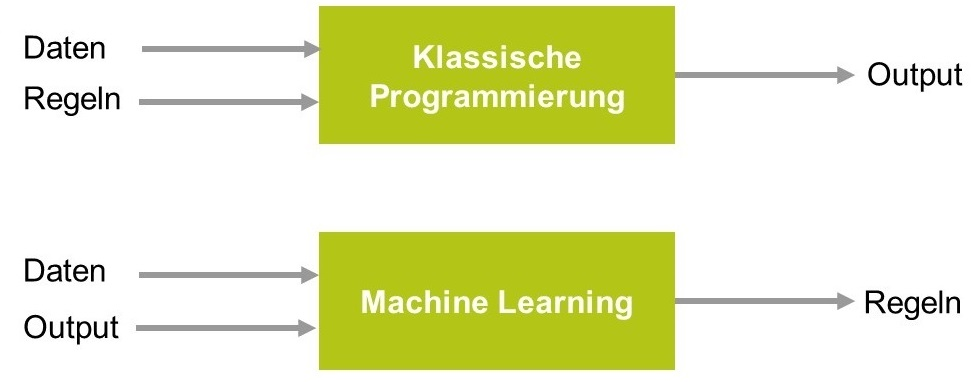

Dazu wird ein Convolutional Neural Network (CNN), eine Unterform eines Nuuronalen Netzes, verwendet. Es ist vom Aufbau der menschlichen Sehrinde nachempfunden und wird vor allem für Anwendungen in der Bild- und Spracherkennung genutzt.
Ohne auf die ganz genauen Details einzugehen, kann allgemein gesagt werden, dass Neuronale Netze einen Input verarbeiten, indem verschiedene sogenannte Hidden Layer durchlaufen werden. Jede dieser Schichten ist aus Neuronen aufgebaut, die mit allen Neuronen der vorangegangenen Schicht vernetzt sind. Die letzte dieser Schichten ist dann die Ausgabeschicht aus der die Vorhersage des Neuronalen Netzes entnehmen können.

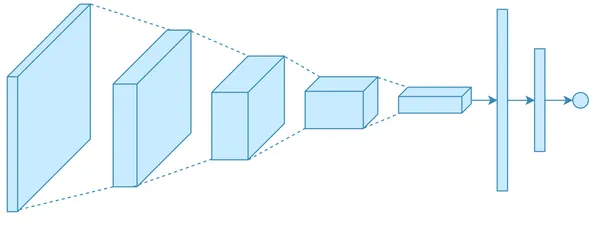


In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

'''Initialisiere das Convolutional Neural Network'''
# Ein sequentielles Modell wird erstellt
classifier= Sequential()

''' Schritt-1 Convolution
# Füge die erste Schicht des CNN hinzu
# Es bedeutet, dass 3 Matrizen der Größe (64X64) Pixel verwendet werden, die die Rot-, Grün- und Blauanteile der Pixel repräsentieren.
'''
classifier.add(Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128,128,3), activation='relu'))

'''Schritt-2 MAX Pooling'''
# Füge eine MaxPooling-Schicht mit einem Pool-Größe von 2x2 hinzu
classifier.add(MaxPool2D(pool_size=(2,2)))

'''Zusätzliche Convolution-Schicht für bessere Genauigkeit'''
# Eine zusätzliche Convolution-Schicht wird hinzugefügt, um eine bessere Genauigkeit zu erzielen.
# Es hat 64 Filter, eine Filtergröße von 3x3 und eine Aktivierungsfunktion "relu".
classifier.add(Convolution2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))

'''Schritt-3 FLattening'''
# Die Ausgabe der vorherigen Schichten wird zu einem flachen Vektor umgewandelt.
classifier.add(Flatten())

'''Schritt-4 Fully Connected Neural Network'''
# Eine Fully Connected Neural Network-Schicht mit 256 Neuronen und einer Aktivierungsfunktion "relu" wird hinzugefügt.
classifier.add(Dense(256, activation='relu'))

# Eine Fully Connected Neural Network-Schicht mit einer Anzahl von Neuronen gleich der Anzahl der Klassen (OutputNeurons) und einer Aktivierungsfunktion "softmax" wird hinzugefügt.
classifier.add(Dense(OutputNeurons, activation='softmax'))

'''Compiling the CNN'''
# Das Modell wird mit 'categorical_crossentropy' als Loss-Funktion, 'rmsprop' als Optimizer und Accuracy als Metrik kompiliert.
classifier.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=["accuracy"])


### Training

Im nächsten Schritt kann nun das Modell trainiert werden. Das Training wird mit der Funktion `classifier.fit_generator()` gestartet. Der Parameter "epochs" bestimmt dabei wie oft wir über die gesamte Menge der Trainingsdaten iteriert wird.

Am Ende eines Durchgangs durch alle Trainingsbilder ("Epoch") erhalten wir ein paar wichtige Werte:
* `val_acc` "Validation Accuracy" sagt, wie gut die Validierungsdaten erkannt wurden
* `val_loss` "Validation Loss" ist der entsprechende Fehler bezogen auf die Validerungsdaten
* `acc` "Training Accuracy" sagt, wie gut die Trainingsdaten erkannt wurden
* `loss` "Training Loss" ist der entsprechende Fehler bezogen auf die Trainingsdaten

Falls die Validation Accuracy deutlich kleiner als die Training Accuracy ist, liegt ein "overfitting" vor. Der Effekt beschreibt, dass das Modell quasi nur die Trainingsdaten auswendig gelernt hätte und nicht gut generalisiert. Damit würden unbekannte Daten nur schlecht vorhergesagt.

In [7]:
import time
# Trainingszeit messen
StartTime=time.time()

# Modelltraining starten
model_history=classifier.fit_generator(
                                        training_set,
                                        steps_per_epoch=len(training_set),
                                        epochs=10,
                                        validation_data=valid_set,
                                        validation_steps=len(valid_set),
                                        verbose=1)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

<ipython-input-7-5bab2da064be>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=classifier.fit_generator(


Epoch 1/10
1/1 [==============================] - 16s 16s/step - loss: 0.6990 - accuracy: 0.6000 - val_loss: 1.3884 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 700ms/step - loss: 1.1865 - accuracy: 0.6000 - val_loss: 36.7351 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 693ms/step - loss: 34.4274 - accuracy: 0.5000 - val_loss: 1.3638 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 700ms/step - loss: 1.3173 - accuracy: 0.5000 - val_loss: 2.7568 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 2.6959 - accuracy: 0.5000 - val_loss: 7.6553 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 1s 907ms/step - loss: 7.1040 - accuracy: 0.5000 - val_loss: 0.6112 - val_accuracy: 0.6250
Epoch 7/10
1/1 [==============================] - 1s 934ms/step - loss: 0.5555 - accuracy: 0.7500 - val_loss: 0.5694 - val_accuracy: 0.7500
Epoch 8/10
1/1 [======

Zur Überprüfung kann der Trainingsfortschritt auch grafisch visualisiert werden:

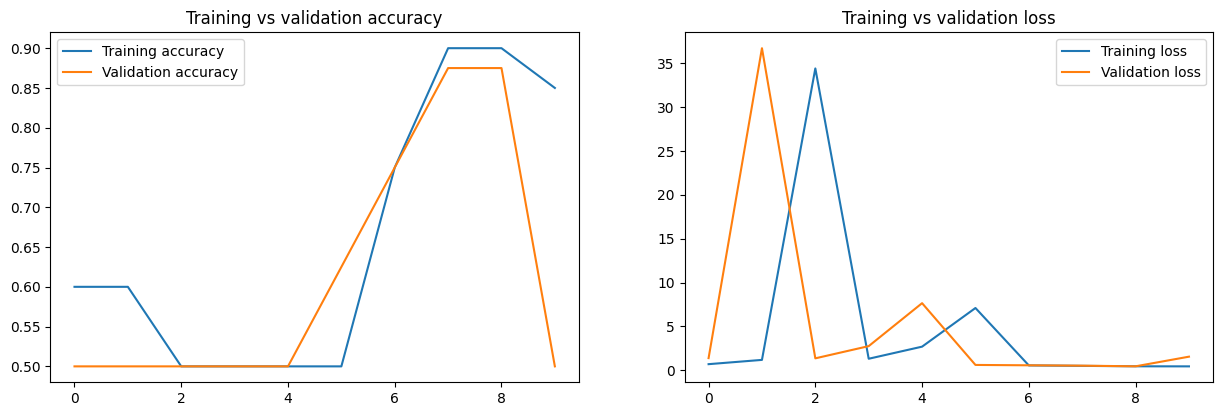

In [8]:
# Trainingshistorie laden
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Daten visualisieren
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Trainiertes Modell speichern

In [9]:
## Modell speichern
classifier.save(f"{path}/classifier.pkl")

### Vorhersage

Nun kann das trainierte Modell angewendet werden, um Bilder zu klassifizieren, die im Unterverzeichnis 'test' abgelegt sind. Anders ausgedrückt: Wir sagen für eine Menge Daten (= ein Bild) vorher, mit jeweils welcher Wahrscheinlichkeit diese Daten ein Mähdrescher bzw. ein Traktor ist.

> 🚩 **Passe den Pfad der Variable 'testImage' an und führe das Snippet aus, um das entsprechende Bild durch zu klassifizieren. Wurde das Bild richtig zugeordnet? Passe den Pfad  an den Filenamen der weiteren Testbilder an und führe das Snippet erneut aus. Wie ist das Ergebnis?**

1/1 [==============================] - 0s 115ms/step


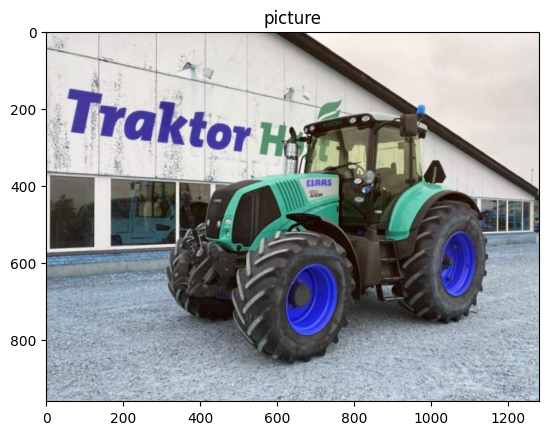

########################################
Prediction is:  tractors


In [13]:
from tensorflow.keras.utils import load_img, img_to_array

testImage= f"{path}/test/tractors/testtractor.jpg" # Pfad ggf. anpassen
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)

img = cv2.imread(testImage)

plt.imshow(img)
plt.title('picture')
plt.show()

print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

### Nächste Schritte


> 🚩 
*   **Erweitere die Datengrundlage um zusätzliche Bilder. Wie wirkt sich eine größere Anzahl auf Bildern auf die Genauigkeit aus?**
*   **Erweiterung des Modells, sodass es auch andere Produkte von CLAAS erkennt.**